<a href="https://colab.research.google.com/github/GITBSB/DL-A2/blob/main/DL_exercise_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.rcParams['figure.figsize'] = 10, 8

Einige Hilfsfunktionen:

In [ ]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

Vorwärtslauf durch das Netzwerk für Testläufe (Prädiktion):

In [ ]:
def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

Backpropagation-Algorithmus für ein Paar aus Input x und Label y:

In [ ]:
def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""
    
    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)
    
    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert 
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

Gemitteltes Update über einen Minibatch:

In [ ]:
def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]
    
    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()
        
        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)
        
        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]
    
    return (weights, biases)

Hilfsfunktion zur Evaluation des Netzwerkes auf den Testdaten:

In [ ]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    mse = 0
    
    # Gehe den Testdatensatz durch
    for i in range(x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        mse += ((ypred-y)**2)/x2.shape[0];
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if (ypred < 0.5 and y == 0) or (ypred >= 0.5 and y == 1):
            correct += 1
        
    return correct, mse

Stochastischer Gradientenabstieg:


In [ ]:
def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten
    
    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    mse_val = np.zeros(epochs)
    for j in range(epochs):
        
        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]
        
        # Zerlege den permutierten Datensatz in Minibatches 
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)
        
        # Gib Performance aus
        acc_val[j], mse_val[j] = evaluate(x2, y2)
        print("Epoch {0}: {1} / {2} - MSE {3}".format(j, acc_val[j], n_test, mse_val[j]))
    
    return acc_val, mse_val

## 1. Spielzeugdatensatz

**1.1 & 1.2**

In [ ]:
def generate_data(l_range, u_range, num):

    # Array erzeugen
    data = np.random.uniform(l_range, u_range,(num,2))
    # Klassenlabel erzeugen
    labels = []
    
    for i, point in enumerate(data):
        x, y = point
        if (x < 0 and y < 0) or (x > 0 and y > 0):
            labels.append(1)
        else:
            labels.append(0)
    return np.asarray(data), np.asarray(labels)

In [ ]:
l_range = -6.0
u_range = 6.0
num_data = 200
np.random.seed(191220293)
x0, y0 = generate_data(l_range, u_range, num_data)
np.random.seed(191220294)
x2, y2 = generate_data(l_range, u_range, num_data)

**1.3**

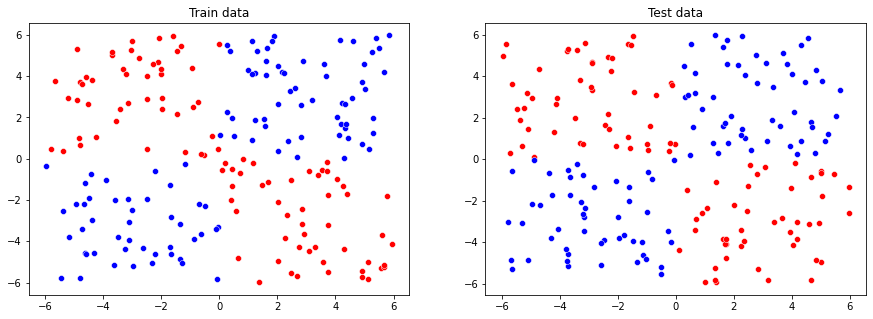

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

x0_0 = x0[y0 == 0]
x0_1 = x0[y0 == 1]
sns.scatterplot(x=x0_0[:, 0], y=x0_0[:, 1], color='red', ax=axes[0])
sns.scatterplot(x=x0_1[:, 0], y=x0_1[:, 1], color='blue', ax=axes[0])
axes[0].set_title("Train data")

x2_0 = x2[y2 == 0]
x2_1 = x2[y2 == 1]
sns.scatterplot(x=x2_0[:, 0], y=x2_0[:, 1], color='red', ax=axes[1])
sns.scatterplot(x=x2_1[:, 0], y=x2_1[:, 1], color='blue', ax=axes[1])
axes[1].set_title("Test data");

**1.4**

In [ ]:
w1 = (1, 0)
w2 = (0, 1)

$$
    w_{1}=\left( \begin{array}{c}
 1 \\ 
 0
\end{array} \right)
$$
und  
$$
    w_{2}=\left( \begin{array}{c}
 0 \\ 
 1
\end{array} \right)
$$

da entwerder am x-Wert oder y-Wert 

**1.5**

In [ ]:
x, y = np.meshgrid(np.arange(-6., 6.1, 0.12), np.arange(-6., 6.1, 0.12))
n = x.shape[0]
s = np.zeros(np.shape(x),dtype=np.float64)

for i in range(n):
  for j in range(n):
    s[i, j] = sigmoid(x[i,j])

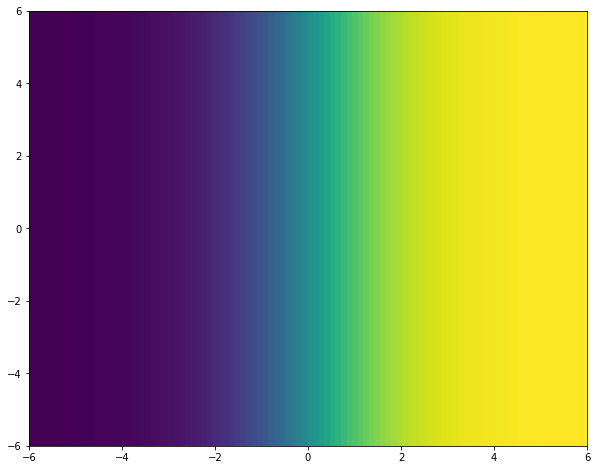

In [ ]:
plt.pcolor(x, y, s)

In [ ]:
x, y = np.meshgrid(np.arange(-6., 6.1, 0.12), np.arange(-6., 6.1, 0.12))
n = x.shape[0]
s = np.zeros(np.shape(x),dtype=np.float64)

for i in range(n):
  for j in range(n):
    s[i, j] = sigmoid(y[i,j])

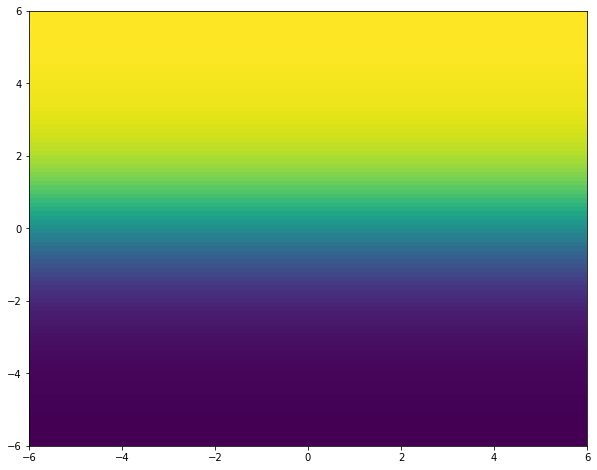

In [ ]:
plt.pcolor(x, y, s)

**1.6**

In [ ]:
training_x = sigmoid(x0)
test_x = sigmoid(x2)

x_s = sigmoid(x)
y_s = sigmoid(y)

## 2. Training eines MLPs auf den Spielzeugdaten

In [ ]:
# Netzwerkparameter
mbs = 10                     # Größe der Minibatches
eta = 1                # Lernrate
no_hidden1 = 2              # Anzahl versteckter Neuronen
no_hidden2 = 2
epochs = 150                 # Anzahl Epochen
sizes = [2, no_hidden1, no_hidden2, 1] # 2 Eingangsneuronen, 2 verdeckte Schichten mit jeweils 2 Neuronen und 1 Ausgangsneuron
num_layers = len(sizes)      # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte
print(weights[2].shape)

(1, 2)


**2.3**

In [ ]:
acc_val, mse_val = SGD(training_x, y0, epochs, mbs, eta, training_x, y0)

Epoch 0: 105.0 / 200 - MSE 0.25028702688841264
Epoch 1: 104.0 / 200 - MSE 0.24961532000699507
Epoch 2: 91.0 / 200 - MSE 0.24988903056877607
Epoch 3: 96.0 / 200 - MSE 0.2512972171533428
Epoch 4: 104.0 / 200 - MSE 0.2495580629453595
Epoch 5: 104.0 / 200 - MSE 0.2495606231743519
Epoch 6: 96.0 / 200 - MSE 0.2504236010668265
Epoch 7: 104.0 / 200 - MSE 0.2501362911873767
Epoch 8: 104.0 / 200 - MSE 0.2507482347690817
Epoch 9: 104.0 / 200 - MSE 0.2526356406502046
Epoch 10: 104.0 / 200 - MSE 0.24952553216179812
Epoch 11: 104.0 / 200 - MSE 0.24954168960969286
Epoch 12: 104.0 / 200 - MSE 0.24973301243854332
Epoch 13: 104.0 / 200 - MSE 0.24946478564905644
Epoch 14: 104.0 / 200 - MSE 0.24968203337588685
Epoch 15: 104.0 / 200 - MSE 0.2494509798724295
Epoch 16: 104.0 / 200 - MSE 0.24947965389681423
Epoch 17: 104.0 / 200 - MSE 0.2494185025566951
Epoch 18: 104.0 / 200 - MSE 0.24945872129008964
Epoch 19: 104.0 / 200 - MSE 0.2493964927487313
Epoch 20: 104.0 / 200 - MSE 0.2507510275036674
Epoch 21: 98.0 /

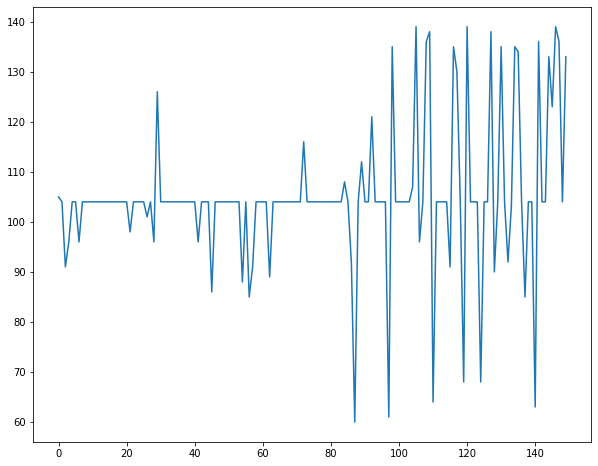

In [ ]:
plt.plot(acc_val)

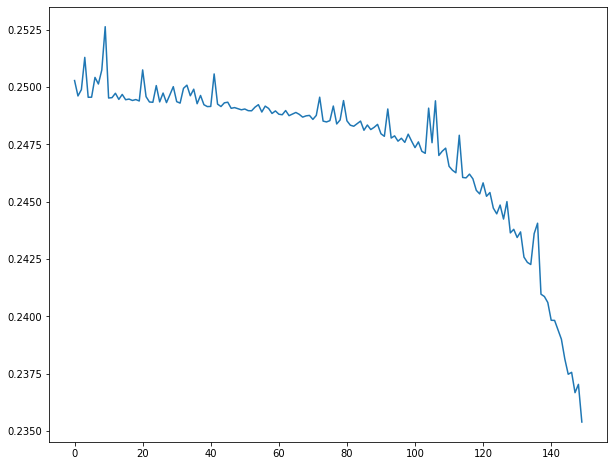

In [ ]:
plt.plot(mse_val)

In [ ]:
test_acc, test_mse = evaluate(test_x, y2)
print("Genauigkeit: {0}/200 - MSE: {1}".format(test_acc, test_mse[0][0]))

Genauigkeit: 134/200 - MSE: 0.23425424769300496


In [ ]:
def plot_grid():
    x, y = np.meshgrid(np.arange(-6., 6.1, 0.122), np.arange(-6., 6.1, 0.122))
    n = x.shape[0]
    e = np.zeros(np.shape(x),dtype=np.float64)

    for i in range(n):
        for j in range(n):
            e[i, j] = feedforward(np.array([[x_s[i, j]], [y_s[i,j]]]))[0]


    plt.pcolor(x, y, e)
    x0_0 = x0[y0 == 0]
    x0_1 = x0[y0 == 1]
    plt.scatter(x=x0_0[:, 0], y=x0_0[:, 1], c='red')
    plt.scatter(x=x0_1[:, 0], y=x0_1[:, 1], c='blue')
    plt.show

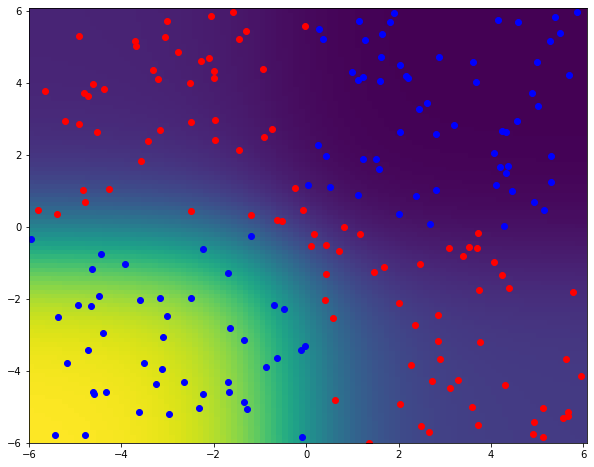

In [ ]:
plot_grid()

## 3. Nachvollziehen der Beispiele aus der Vorlesung

In [ ]:
# Tanh
def sigmoid(z):
    """The tanh function."""
    return np.tanh(z)

# Ableitung des Tanh
def sigmoid_prime(z):
    """Derivative of the tanh function."""
    return (1 - np.tanh(z)**2)

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    return (output_activations-y)

def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    mse = 0
    
    # Gehe den Testdatensatz durch
    for i in range(x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        mse += ((ypred-y)**2)/x2.shape[0];
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if (ypred < 0 and y == -1) or (ypred >= 0 and y == 1):
            correct += 1
        
    return correct, mse

**Label anpassen**

In [ ]:
def generate_data(l_range, u_range, num):

    # Array erzeugen
    data = np.random.uniform(l_range, u_range,(num,2))
    # Klassenlabel erzeugen
    labels = []
    
    for i, point in enumerate(data):
        x, y = point
        if (x < 0 and y < 0) or (x > 0 and y > 0):
            labels.append(1)
        else:
            labels.append(-1)
    return np.asarray(data), np.asarray(labels)

In [ ]:
l_range = -6.0
u_range = 6.0
num_data = 200
np.random.seed(191220293)
x0, y0 = generate_data(l_range, u_range, num_data)
np.random.seed(191220294)
x2, y2 = generate_data(l_range, u_range, num_data)

In [ ]:
def plot_grid():
    x, y = np.meshgrid(np.arange(-6., 6.1, 0.122), np.arange(-6., 6.1, 0.122))
    n = x.shape[0]
    e = np.zeros(np.shape(x),dtype=np.float64)

    for i in range(n):
        for j in range(n):
            e[i, j] = feedforward(np.array([[x_s[i, j]], [y_s[i,j]]]))[0]


    plt.pcolor(x, y, e)
    x0_0 = x0[y0 == -1]
    x0_1 = x0[y0 == 1]
    plt.scatter(x=x0_0[:, 0], y=x0_0[:, 1], c='red')
    plt.scatter(x=x0_1[:, 0], y=x0_1[:, 1], c='blue')
    plt.show

**Vesteckte Schicht mit 2 Neuronen**

In [ ]:
# Netzwerkparameter
mbs = 10                     # Größe der Minibatches
eta = 0.03                 # Lernrate
no_hidden = 2              # Anzahl versteckter Neuronen
epochs = 150                 # Anzahl Epochen
sizes = [2, no_hidden, 1] # 2 Eingangsneuronen, 1 Ausgangsneuron
num_layers = len(sizes)      # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte

acc_val, mse_val = SGD(training_x, y0, epochs, mbs, eta, training_x, y0)

Epoch 0: 96.0 / 200 - MSE 2.0164466477576335
Epoch 1: 96.0 / 200 - MSE 2.004877297347522
Epoch 2: 96.0 / 200 - MSE 1.9884909725252546
Epoch 3: 96.0 / 200 - MSE 1.9638041050058066
Epoch 4: 96.0 / 200 - MSE 1.9233823536396057
Epoch 5: 96.0 / 200 - MSE 1.8503116684872483
Epoch 6: 96.0 / 200 - MSE 1.7045233477289963
Epoch 7: 96.0 / 200 - MSE 1.469426392319288
Epoch 8: 96.0 / 200 - MSE 1.309036361158939
Epoch 9: 113.0 / 200 - MSE 1.2488633400861713
Epoch 10: 113.0 / 200 - MSE 1.221384635425167
Epoch 11: 105.0 / 200 - MSE 1.192852819797144
Epoch 12: 104.0 / 200 - MSE 1.1636344421263431
Epoch 13: 101.0 / 200 - MSE 1.1359805459860628
Epoch 14: 100.0 / 200 - MSE 1.1114961369208476
Epoch 15: 100.0 / 200 - MSE 1.0897974432002433
Epoch 16: 101.0 / 200 - MSE 1.0717187108500463
Epoch 17: 101.0 / 200 - MSE 1.0569290902930801
Epoch 18: 101.0 / 200 - MSE 1.0437433542408256
Epoch 19: 102.0 / 200 - MSE 1.0322848637301174
Epoch 20: 103.0 / 200 - MSE 1.022192717847967
Epoch 21: 103.0 / 200 - MSE 1.01338341

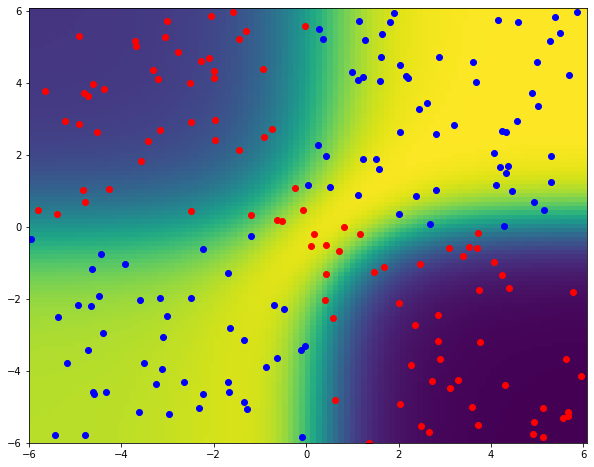

In [ ]:
plot_grid()

**Vesteckte Schicht mit 3 Neuronen**

In [ ]:
# Netzwerkparameter
mbs = 10                     # Größe der Minibatches
eta = 0.03                 # Lernrate
no_hidden = 3              # Anzahl versteckter Neuronen
epochs = 150                 # Anzahl Epochen
sizes = [2, no_hidden, 1] # 2 Eingangsneuronen, 1 Ausgangsneuron
num_layers = len(sizes)      # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte

acc_val, mse_val = SGD(training_x, y0, epochs, mbs, eta, training_x, y0)

Epoch 0: 121.0 / 200 - MSE 0.9894083700344191
Epoch 1: 99.0 / 200 - MSE 0.9816558001923422
Epoch 2: 93.0 / 200 - MSE 0.9775488104682097
Epoch 3: 112.0 / 200 - MSE 0.9727033667785784
Epoch 4: 95.0 / 200 - MSE 0.9692568966789158
Epoch 5: 96.0 / 200 - MSE 0.9659593936820057
Epoch 6: 106.0 / 200 - MSE 0.9620485960101817
Epoch 7: 146.0 / 200 - MSE 0.959527053413481
Epoch 8: 146.0 / 200 - MSE 0.954932206057825
Epoch 9: 134.0 / 200 - MSE 0.9500311333931487
Epoch 10: 130.0 / 200 - MSE 0.94611281247792
Epoch 11: 138.0 / 200 - MSE 0.9410469125306128
Epoch 12: 140.0 / 200 - MSE 0.9361627684392974
Epoch 13: 146.0 / 200 - MSE 0.9321924429938315
Epoch 14: 146.0 / 200 - MSE 0.9257078194658763
Epoch 15: 144.0 / 200 - MSE 0.919122786104021
Epoch 16: 130.0 / 200 - MSE 0.9129864544255571
Epoch 17: 144.0 / 200 - MSE 0.9053428005550057
Epoch 18: 148.0 / 200 - MSE 0.899995661459468
Epoch 19: 141.0 / 200 - MSE 0.8891818274319163
Epoch 20: 144.0 / 200 - MSE 0.8808282384607823
Epoch 21: 136.0 / 200 - MSE 0.870

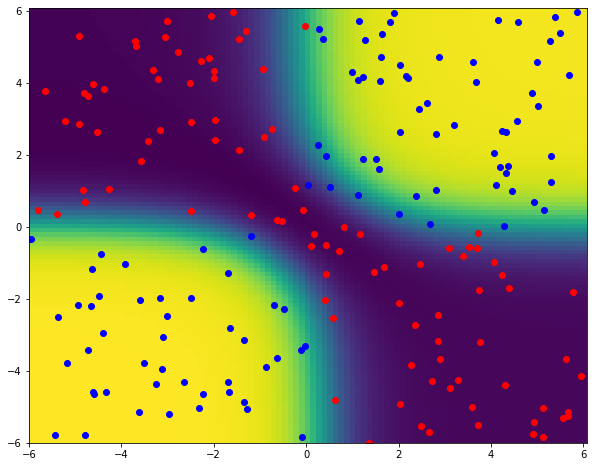

In [ ]:
plot_grid()

**Zwei versteckte Schichten**


In [ ]:
# Netzwerkparameter
mbs = 10                     # Größe der Minibatches
eta = 0.03                 # Lernrate
no_hidden1 = 3
no_hidden2 = 2                
epochs = 150                 # Anzahl Epochen
sizes = [2, no_hidden1, no_hidden2, 1] # 2 Eingangsneuronen, 1 Ausgangsneuron
num_layers = len(sizes)      # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte

acc_val, mse_val = SGD(training_x, y0, epochs, mbs, eta, training_x, y0)

Epoch 0: 133.0 / 200 - MSE 0.9353252989157338
Epoch 1: 143.0 / 200 - MSE 0.908385951393747
Epoch 2: 144.0 / 200 - MSE 0.892618475095518
Epoch 3: 142.0 / 200 - MSE 0.8787974982603953
Epoch 4: 141.0 / 200 - MSE 0.867266724653661
Epoch 5: 143.0 / 200 - MSE 0.8572514443798711
Epoch 6: 142.0 / 200 - MSE 0.8475371498824439
Epoch 7: 140.0 / 200 - MSE 0.838909094531806
Epoch 8: 140.0 / 200 - MSE 0.830287700118358
Epoch 9: 141.0 / 200 - MSE 0.8208057873598575
Epoch 10: 143.0 / 200 - MSE 0.8110478301453197
Epoch 11: 142.0 / 200 - MSE 0.7993821221054055
Epoch 12: 142.0 / 200 - MSE 0.7859388629959315
Epoch 13: 142.0 / 200 - MSE 0.7698131808780891
Epoch 14: 142.0 / 200 - MSE 0.751171281526831
Epoch 15: 144.0 / 200 - MSE 0.7268709978929762
Epoch 16: 144.0 / 200 - MSE 0.6969730151234084
Epoch 17: 159.0 / 200 - MSE 0.662433080863808
Epoch 18: 169.0 / 200 - MSE 0.6243715960318313
Epoch 19: 174.0 / 200 - MSE 0.5864282521267611
Epoch 20: 180.0 / 200 - MSE 0.5468379113507569
Epoch 21: 181.0 / 200 - MSE 0.

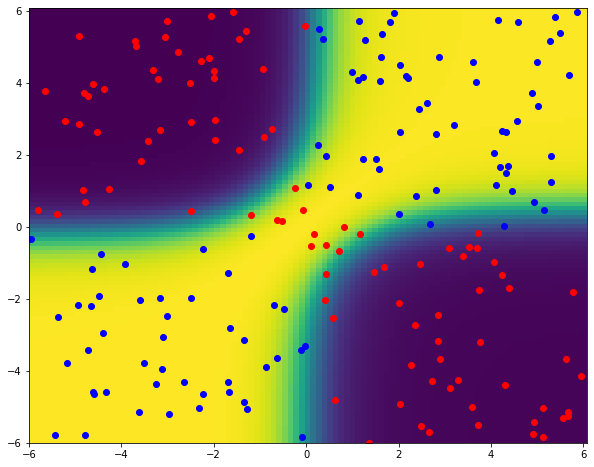

In [ ]:
plot_grid()

## 4. Logistische Regression

In [58]:
# Sigmoid (vektorisiert)
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

# Ableitung der MSE-Kostenfunktion
def cost_derivative(output_activations, y):
    """Return the vector of partial derivatives \partial C_x /
    \partial a for the output activations."""
    #return (output_activations-y)
    dC = (-1*(output_activations - y)) / ((output_activations - 1) * output_activations)
    dC = np.nan_to_num(dC)
    return dC

In [59]:
def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""
    
    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    mse = 0
    costlog = 0
    
    # Gehe den Testdatensatz durch
    for i in range(x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        if len(y2.shape) == 2:
            y = np.reshape(y2[i,:],(y2.shape[1],1)).copy()
        else:
            y = y2[i].copy()
        
        # Vorwärtslauf
        ypred = feedforward(x)
        
        #mse += ((ypred-y)**2)/x2.shape[0];

        ### Kostenfunktion logistische Regression
        costlog += -y * np.log(ypred) - ((1 - y) * np.log(1 - ypred));
        cost = np.nan_to_num(costlog)
        
        # Falls beide übereinstimmen, addiere zur Gesamtzahl
        if (ypred < 0.5 and y == 0) or (ypred >= 0.5 and y == 1):
            correct += 1
        
    return correct, cost

In [60]:
def generate_data(l_range, u_range, num):

    # Array erzeugen
    data = np.random.uniform(l_range, u_range,(num,2))
    # Klassenlabel erzeugen
    labels = []
    
    for i, point in enumerate(data):
        x, y = point
        if (x < 0 and y < 0) or (x > 0 and y > 0):
            labels.append(1)
        else:
            labels.append(0)
    return np.asarray(data), np.asarray(labels)

In [61]:
l_range = -6.0
u_range = 6.0
num_data = 200
np.random.seed(191220293)
x0, y0 = generate_data(l_range, u_range, num_data)
np.random.seed(191220294)
x2, y2 = generate_data(l_range, u_range, num_data)

In [62]:
training_x = sigmoid(x0)
test_x = sigmoid(x2)

x_s = sigmoid(x)
y_s = sigmoid(y)

In [63]:
# Netzwerkparameter
mbs = 10                     # Größe der Minibatches
eta = 1.0                 # Lernrate
no_hidden = 2              # Anzahl versteckter Neuronen
epochs = 150                 # Anzahl Epochen
sizes = [2, no_hidden, 1] # 2 Eingangsneuronen, 1 Ausgangsneuron
num_layers = len(sizes)      # Anzahl Schichten

# Arrays für Gewichte und Schwellwerte (initialisiert mit Gaußschem Rauschen)
biases = [np.random.randn(y, 1) for y in sizes[1:]] # Schwellwerte
weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])] #Gewichte

acc_val, log_val = SGD(training_x, y0, epochs, mbs, eta, training_x, y0)

Epoch 0: 101.0 / 200 - MSE 138.98075705424247
Epoch 1: 96.0 / 200 - MSE 142.02999838747604
Epoch 2: 107.0 / 200 - MSE 138.35665943470326
Epoch 3: 94.0 / 200 - MSE 139.3538582338562
Epoch 4: 111.0 / 200 - MSE 138.11788237390948
Epoch 5: 96.0 / 200 - MSE 146.35844580911828
Epoch 6: 104.0 / 200 - MSE 145.81920709267123
Epoch 7: 115.0 / 200 - MSE 137.62511153835757
Epoch 8: 60.0 / 200 - MSE 138.76389788845793
Epoch 9: 137.0 / 200 - MSE 137.1614789701091
Epoch 10: 96.0 / 200 - MSE 139.83631805678942
Epoch 11: 138.0 / 200 - MSE 136.36739077722657
Epoch 12: 116.0 / 200 - MSE 138.90446462643365
Epoch 13: 104.0 / 200 - MSE 142.21866382590846
Epoch 14: 67.0 / 200 - MSE 137.1407780601806
Epoch 15: 132.0 / 200 - MSE 132.54417823340754
Epoch 16: 137.0 / 200 - MSE 131.10936363620243
Epoch 17: 142.0 / 200 - MSE 130.2066120330646
Epoch 18: 140.0 / 200 - MSE 128.03086120034567
Epoch 19: 96.0 / 200 - MSE 133.9752759655213
Epoch 20: 142.0 / 200 - MSE 124.70561156575907
Epoch 21: 143.0 / 200 - MSE 123.061

In [65]:
def plot_grid():
    x, y = np.meshgrid(np.arange(-6., 6.1, 0.122), np.arange(-6., 6.1, 0.122))
    n = x.shape[0]
    e = np.zeros(np.shape(x),dtype=np.float64)

    for i in range(n):
        for j in range(n):
            e[i, j] = feedforward(np.array([[x_s[i, j]], [y_s[i,j]]]))[0]


    plt.pcolor(x, y, e)
    x0_0 = x0[y0 == 0]
    x0_1 = x0[y0 == 1]
    plt.scatter(x=x0_0[:, 0], y=x0_0[:, 1], c='red')
    plt.scatter(x=x0_1[:, 0], y=x0_1[:, 1], c='blue')
    plt.show

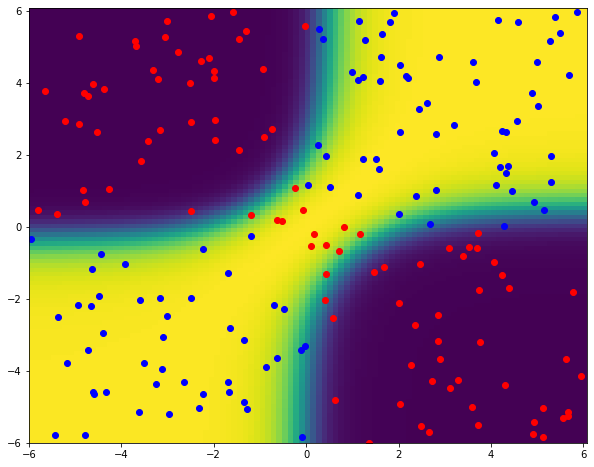

In [67]:
plot_grid()